# Combine and Align Several Spectra from TIC 170729775 

In [31]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate
from scipy.stats import sigmaclip
import os


from funcs import align_spectra
#from funcs.Functions_spectra import collect_fits_files 

from astroquery.simbad import Simbad

def query_tic_name(target_name):
    custom_simbad = Simbad()
    custom_simbad.add_votable_fields("ids")
    
    result_table = custom_simbad.query_object(target_name)
    
    if result_table is not None and len(result_table) > 0:
        ids = result_table['IDS'][0].split("|")
        tic_name = next((id for id in ids if id.startswith("TIC ")), None)
        if tic_name is not None:
            tic_name = tic_name.split("TIC ")[1]
        return 'TIC'+tic_name
    
    return "Unknown"

from astropy.io import fits

def extract_target_info_astropy(fits_file):
    # Open the FITS file
    with fits.open(fits_file) as hdul:
        # Get the primary header
        header = hdul[0].header
        
        #print(header)

        # Extract the target name and observed night
        target_name = header.get('OBJECT', 'Unknown')
        observed_night = header.get('DATE-OBS', 'Unknown')
        
        if target_name == "Unknwon" or observed_night == "Unknown":
            target_name, observed_night = extract_target_info(fits_file)
            

    return target_name, observed_night

import os

def extract_target_info(fits_file):
    # Extract target name and observed night from file name
    file_name = os.path.splitext(os.path.basename(fits_file))[0]
    target_name, observed_night = file_name.split('_')

    return target_name, observed_night


# Example usage
#target_name = "CD-341735"

#tic_name = query_tic_name(target_name)
#print("TIC Name:", tic_name)


def align_spectra(spectrum1, spectrum2):
    
    '''
    Align two spectra based on their flux values using cross-correlation.
    
    If the observation nights correspond to different time frames, using cross-correlation 
    to align the spectra can account for any time shifts and ensure that the spectra are properly 
    aligned in the time domain.
    
    Args:
        spectrum1 (ndarray): 
            First spectrum to align.
        spectrum2 (ndarray): 
            Second spectrum to align.
    
    Returns:
        spectrum2_shifted (ndarray): 
            Second spectrum shifted to align with the first spectrum.
        
    '''

    # Perform cross-correlation between the spectra to find the same flux values
    correlation = correlate(spectrum1, spectrum2, mode='same')

    # Find the index of the maximum correlation value
    shift_index = np.argmax(correlation)

    # Calculate the shift value
    shift = len(spectrum1) // 2 - shift_index

    # Shift the second spectrum
    spectrum2_shifted = np.roll(spectrum2, shift)

    return spectrum2_shifted



def combine_spectra(nights, order, saturation_threshold=50000, sigma = 3, CERES_spectra = True, blaze_corrected = False):
    
    '''
        Combine spectra from multiple observation nights for a specific order.
        
        Params:
            nights (list): 
                List of FITS file paths corresponding to the observation nights.
            order (int): 
                Order number of the spectra to extract.
            CERES_spectra (bool, optional): 
                Whether the spectra are CERES spectra (default=True).
            blaze_corrected (bool, optional): 
                Whether the spectra are blaze-corrected in CERES (default=False).

        Returns:
            combined_spectrum (ndarray): 
                Combined spectrum for the specified order.

        This function takes a list of FITS file paths corresponding to different observation nights 
        and combines the spectra for a specific order. The function supports CERES spectra and provides 
        the option to specify whether the spectra are blaze-corrected.

        The function loads the FITS files for each night, extracts the specific order and flux based 
        on the provided options, and appends the order spectrum to a list. Then, it aligns the spectra
        using the `align_spectra` function and calculates the median 
        of the aligned spectra to obtain the combined spectrum.

        The combined spectrum for the specified order is returned as a NumPy array.
    '''
    
    
    spectra = []

    for night in nights:
        # Load the FITS file for the night
        hdulist = fits.open(night)
        data = hdulist[0].data

        # Extract the specific order and flux
        
        if CERES_spectra == True: 
            if blaze_corrected == True:
                extension = 3 #blaze corrected flux in CERES 
            else: 
                extension = 1 #flux in CERES
        else:
            print("Til now no other Spectra has been used except CERES, Idn what to do.")
            return 0
        
        order_data = data[extension][order]   #it is one in CERES spectra
        
        ## Here I should check for saturation!!!! An other artifcats 
        # Check for saturation
        if np.max(order_data) > saturation_threshold:
            print(f"Skipping saturated spectrum from night: {night}")
            continue
        
        
        
        # Append the order spectrum to the list
        spectra.append(order_data)
        
        target_name, observed_night = extract_target_info(night)

        # Close the FITS file
        hdulist.close()
        
    spectra = np.array(spectra)
       
    #Apply sigma clipping
    clipped_spectra = []
    for spectrum in spectra:
        clipped_spectrum, lower, upper = sigmaclip(spectrum, low=sigma, high = sigma)
        median_val = np.median(spectrum)
        clipped_spectrum[clipped_spectrum < lower] = median_val
        clipped_spectrum[clipped_spectrum > upper] = median_val
        clipped_spectra.append(clipped_spectrum)

    # Convert the list of clipped spectra into a NumPy array
    clipped_spectra = np.array(clipped_spectra)

    # Align the spectra
    reference_spectrum = clipped_spectra[0]
    aligned_spectra = [reference_spectrum]

    for spectrum in clipped_spectra[1:]:
        aligned_spectrum = align_spectra(reference_spectrum, spectrum)
        aligned_spectra.append(aligned_spectrum)

    # Convert the list of aligned spectra into a NumPy array
    aligned_spectra = np.array(aligned_spectra)

    # Ensure all aligned spectra have the same length
    min_length = min(len(spectrum) for spectrum in aligned_spectra)
    aligned_spectra = np.array([spectrum[:min_length] for spectrum in aligned_spectra])

    # Calculate the median of the aligned spectra along the first axis (night axis)
    combined_spectrum = np.median(aligned_spectra, axis=0)
    
    if target_name.startswith("TIC") == False:
        target_name = query_tic_name(target_name)
        
    target_name = target_name + '.fits'
    
    combined_hdulist = fits.PrimaryHDU(combined_spectrum)
    combined_hdulist.writeto(target_name, overwrite=True)

    return combined_spectrum




    

    


In [2]:
def collect_fits_files(directory):
    
    """Collects all fits files in a directory. 
    
    Parameters:
    directory (str): 
        directory name
    
    Returns:
    fits_files (list): 
        list of fits files. 
    
    """
    
    fits_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.fits'):
            fits_files.append(os.path.join(directory, filename))
    return fits_files

In [47]:
import numpy as np
from astropy.stats import sigma_clip

def combine_spectra(nights, order, saturation_threshold=None, sigma=10.0, CERES_spectra=True, blaze_corrected=False):
    '''
    Combine spectra from multiple observation nights for a specific order.
        
    Params:
        nights (list): 
                List of FITS file paths corresponding to the observation nights.
        order (int): 
                Order number of the spectra to extract.
        CERES_spectra (bool, optional): 
                Whether the spectra are CERES spectra (default=True).
        blaze_corrected (bool, optional): 
                Whether the spectra are blaze-corrected in CERES (default=False).

    Returns:
            combined_spectrum (ndarray): 
                Combined spectrum for the specified order.

    This function takes a list of FITS file paths corresponding to different observation nights 
    and combines the spectra for a specific order. The function supports CERES spectra and provides 
    the option to specify whether the spectra are blaze-corrected.

    The function loads the FITS files for each night, extracts the specific order and flux based 
    on the provided options, and appends the order spectrum to a list. Then, it aligns the spectra
    using the `align_spectra` function and calculates the median 
    of the aligned spectra to obtain the combined spectrum.

    The combined spectrum for the specified order is returned as a NumPy array.
    '''
    spectra = []

    for night in nights:
        # Load the FITS file for the night
        hdulist = fits.open(night)
        data = hdulist[0].data

        # Extract the specific order and flux
        if CERES_spectra:
            if blaze_corrected:
                extension = 3  # blaze corrected flux in CERES
            else:
                extension = 1  # flux in CERES
        else:
            print("Currently, only CERES spectra are supported.")
            return None

        order_data = data[extension][order]

        # Append the order spectrum to the list
        spectra.append(order_data)
        target_name, observed_night = extract_target_info(night)
        # Close the FITS file
        hdulist.close()

    # Convert the list of spectra into a NumPy array
    spectra = np.array(spectra)

    # Apply sigma clipping
    if sigma is not None:
        clipped_spectra = []
        for spectrum in spectra:
            clip_mask = sigma_clip(spectrum, sigma_lower=sigma, sigma_upper=sigma, masked=True)
            clipped_mask = clip_mask.data
            median = np.median(clipped_mask)
            mask = clip_mask.mask
            #print(median)
            masked_spectrum = []
            for i in range(len(mask)): 
                if mask[i] == True: 
                    masked_spectrum.append(median)
                else: 
                    masked_spectrum.append(clipped_mask[i])
            clipped_spectrum = masked_spectrum
            clipped_spectra.append(clipped_spectrum)
        clipped_spectra = np.array(clipped_spectra)
    else:
        clipped_spectra = spectra

    # Align the spectra
    reference_spectrum = clipped_spectra[0]
    aligned_spectra = [reference_spectrum]

    for spectrum in clipped_spectra[1:]:
        aligned_spectrum = align_spectra(reference_spectrum, spectrum)
        aligned_spectra.append(aligned_spectrum)

    # Convert the list of aligned spectra into a NumPy array
    aligned_spectra = np.array(aligned_spectra)

    # Calculate the median of the aligned spectra along the first axis (night axis)
    combined_spectrum = np.median(aligned_spectra, axis=0)
    
    if target_name.startswith("TIC") == False:
        target_name = query_tic_name(target_name)
        
    target_name = target_name + 'order' + str(order) +'.fits'
    
    combined_hdulist = fits.PrimaryHDU(combined_spectrum)
    combined_hdulist.writeto("Spectra/" + target_name, overwrite=True)

    return combined_spectrum

def align_spectra(reference_spectrum, spectrum2):
    
        
    '''
    Align two spectra based on their flux values using cross-correlation.
    
    If the observation nights correspond to different time frames, using cross-correlation 
    to align the spectra can account for any time shifts and ensure that the spectra are properly 
    aligned in the time domain.
    
    Args:
        spectrum1 (ndarray): 
            First spectrum to align.
        spectrum2 (ndarray): 
            Second spectrum to align.
    
    Returns:
        spectrum2_shifted (ndarray): 
            Second spectrum shifted to align with the first spectrum.
        
    '''


    #return aligned_spectrum

    # Perform cross-correlation between the spectra to find the same flux values
    correlation = correlate(reference_spectrum, spectrum2, mode='same') #same

    # Find the index of the maximum correlation value
    shift_index = np.argmax(correlation)

    # Calculate the shift value
    shift = len(reference_spectrum) // 2 - shift_index

    # Shift the second spectrum
    spectrum2_shifted = np.roll(spectrum2, shift)

    return spectrum2_shifted


    

In [4]:
fits_files = collect_fits_files('/home/aaron/Desktop/ZASPE/Spectra/')
#print(fits_files)

In [45]:

#Specify the spectral order to combine
combined_spectra = []
for i in range(70):
    combined_spectrum = combine_spectra(fits_files, i, blaze_corrected=True)
    combined_spectra.append(np.array(combined_spectrum))

combined_spectra = np.array(combined_spectra)

# Save the combined spectrum to a new FITS file
#combined_hdulist = fits.PrimaryHDU(combined_spectrum)
#combined_hdulist.writeto("combined_spectrum.fits", overwrite=True)

In [15]:
#get wavelength for plotting
spectrum = fits.getdata(fits_files[0])
flux = spectrum[1,:]
wavelength = spectrum[0,:]
blaze_corrected_flux = spectrum[3,:]

<IPython.core.display.Javascript object>


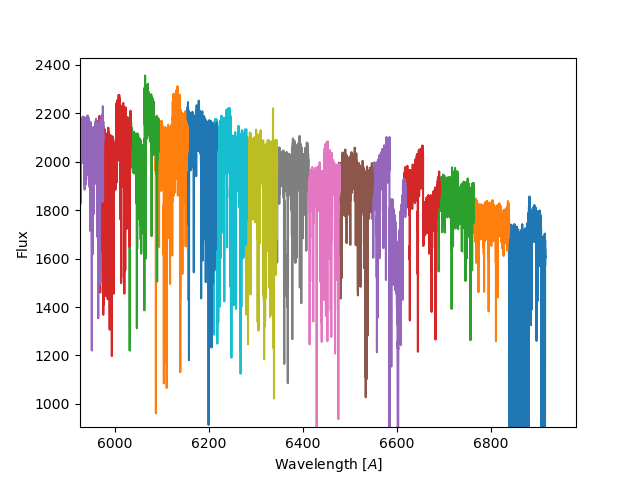

In [46]:
%matplotlib notebook 

import matplotlib.pyplot as plt 
plt.xlabel(r"Wavelength $[A]$")
plt.ylabel(r"Flux")
for i in range(len(wavelength)):
    plt.plot(wavelength[i], combined_spectra[i])
    